In [1]:
import os
import sys

script_folder = os.path.abspath('')
sys.path.append(script_folder)
root_folder = os.path.join(script_folder, os.pardir)

# utility functions to handle asdf data
import read_asdf
import utils

import h5py as h5
import numpy as np
from scipy.interpolate import LinearNDInterpolator, interpn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import cartopy as ctp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely import geometry

# set plotting parameters
import seaborn as sns
sns.set(font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
# I/O variables
path_data = os.path.join(root_folder, 'data')
data_filename = 'data_20120726.h5'
tt_filename = 'tts.h5'
path_tts = os.path.join(path_data, tt_filename)
cnr_filename = 'cnr_NAF_env.h5'

In [3]:
# load the seismic station network's metadata
network_metadata = read_asdf.get_asdf_metadata(
        os.path.join(path_data, data_filename))
print(network_metadata)

          latitude  longitude  elevation network_code station_code
YH.DC06  40.616718  30.265751      555.0           YH         DC06
YH.DC07  40.667080  30.242170      164.0           YH         DC07
YH.DC08  40.744438  30.250130      162.0           YH         DC08
YH.DD06  40.623539  30.317770      182.0           YH         DD06
YH.DE07  40.679661  30.411539       40.0           YH         DE07
YH.DE08  40.748562  30.406469       31.0           YH         DE08
YH.SAUV  40.740200  30.327200      170.0           YH         SAUV
YH.SPNC  40.686001  30.308300      190.0           YH         SPNC


In [4]:
# load data
# these data are really preprocessed: bandpass filtered at 2-12Hz
# and downsampled at 25Hz
data = read_asdf.read_asdf_data(
        os.path.join(path_data, data_filename), network_metadata.index, tag='preprocessed_2_12')
sr = data[0].stats.sampling_rate
time = np.arange(np.datetime64(data[0].stats.starttime),
                 np.datetime64(data[0].stats.endtime),
                 np.timedelta64(int(1000./sr), 'ms'))

In [5]:
# # test:
# components = ['N', 'E', 'Z']
# data_arr = read_asdf.get_np_array(data, network_metadata['station_code'], components)
# print(data_arr[0, 0, :10])

In [6]:
# # test
# try:
#     from scipy.stats import median_abs_deviation as scimad
# except ImportError:
#     from scipy.stats import median_absolute_deviation as scimad
# from scipy.signal import hilbert

# components = ['N', 'E', 'Z']
# data_arr = read_asdf.get_np_array(data, network_metadata['station_code'], components)
# norm = scimad(data_arr, axis=-1)[..., np.newaxis]
# norm[norm == 0.] = 1.
# detection_traces = utils.envelope_parallel(data_arr/norm)
# # clip envelopes so that spikes don't dominate the beam
# scale = scimad(detection_traces, axis=-1)[..., np.newaxis]
# detection_traces = np.clip(detection_traces, np.min(detection_traces, axis=-1, keepdims=True),
#                           10.**5.*scale)


# for i, tr in enumerate(data):
#     ss = network_metadata['station_code'].values.tolist().index(tr.stats.station)
#     cc = components.index(tr.stats.component)
#     data[i].data = detection_traces[ss, cc, :]

In [7]:
# load travel-time table
tts = {}
source_coords = {}
with h5.File(path_tts, mode='r') as f:
    for phase in ['P', 'S']:
        tts[phase] = {}
        for sta_code in f[f'tt_{phase}'].keys():
            tts[phase][sta_code] = f[f'tt_{phase}'][sta_code][()].flatten()
    for coord in f['source_coordinates'].keys():
        source_coords[coord] = f['source_coordinates'][coord][()]     

In [8]:
# define moveouts
phases = ['S', 'S', 'P'] # we'll extract S waves on horizontal components
                         # and P waves on vertical components
#phases = ['P', 'S']
moveouts = utils.get_moveout_array(tts, network_metadata['station_code'], phases)
# express moveouts in terms of relative times
moveouts -= np.min(moveouts, axis=(1, 2), keepdims=True)
moveouts = utils.sec_to_samp(moveouts, sr=sr)

In [9]:
# load the composite network response
with h5.File(os.path.join(path_data, cnr_filename), mode='r') as f:
    cnr = f['cnr'][()]
    cnr_source_indexes = f['source_indexes'][()]
length = min(len(time), len(cnr))
time = time[:length]
cnr = cnr[:length]
cnr_source_indexes = cnr_source_indexes[:length]

In [10]:
# define the detection threshold
# --- use a time-dependent threshold when using the envelopes as detection traces
sliding_window = int(0.5*3600.*sr) # duration in samples
overlap = 0.75
CNR_threshold = 15. # N MADs
detection_threshold = utils.time_dependent_threshold(
     cnr, sliding_window, overlap=overlap, CNR_threshold=CNR_threshold)
# --- use a fixed threshold when using PhaseNet's probabilities as detection traces
#detection_threshold = 1.0*np.ones(len(cnr), dtype=np.float32)

In [11]:
# get the detections
minimum_time = int(30.*sr) # minimum time, in samples, between two consecutive detections
# -- duration of the time windows extracted on each channel
duration = 8.
# -- time, in seconds, taken before the pick to define the beginning of each window, per channel
offset_start = [4., 4., 1.]
detections, peaks, source_indexes = utils.find_detections(
    data, cnr, cnr_source_indexes, moveouts, detection_threshold,
    network_metadata['station_code'].values, ['N', 'E', 'Z'],
    minimum_time, duration, offset_start=offset_start)

Extracted 170 events.


In [12]:
def plot_cnr(ax=None, det_idx=None):
    if ax is None:
        # plot the composite network response
        fig = plt.figure('composite_network_response', figsize=(20, 7))

        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()

    ax.plot(time, cnr)
    ax.plot(time, detection_threshold, color='C3', ls='--',
            label=f'Detection threshold: Median(t) + {CNR_threshold:.1f}xMAD(t)')
    ax.plot(time[peaks], cnr[peaks], marker='o', ls='', color='C3')
    ax.legend(loc='upper right')
    ax.set_xlabel('Time of the day')
    ax.set_ylabel('Composite Network Response')

    ax.set_xlim(time.min(), time.max())
    #ax.set_ylim(-0.1*(detection_threshold.max() - cnr.min()), 1.2*detection_threshold.max())
    #ax.set_ylim(-0.1*(detection_threshold.max() - cnr.min()), 1.2*detection_threshold.max())
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    if det_idx is not None:
        ax.annotate('detection', (time[peaks[det_idx]], cnr[peaks[det_idx]]),
                    (time[peaks[det_idx]] + np.timedelta64(15, 'm'),
                     min(ax.get_ylim()[1], 2.*cnr[peaks[det_idx]])),
                   arrowprops={'width': 2, 'headwidth': 5, 'color': 'k'})
    return fig

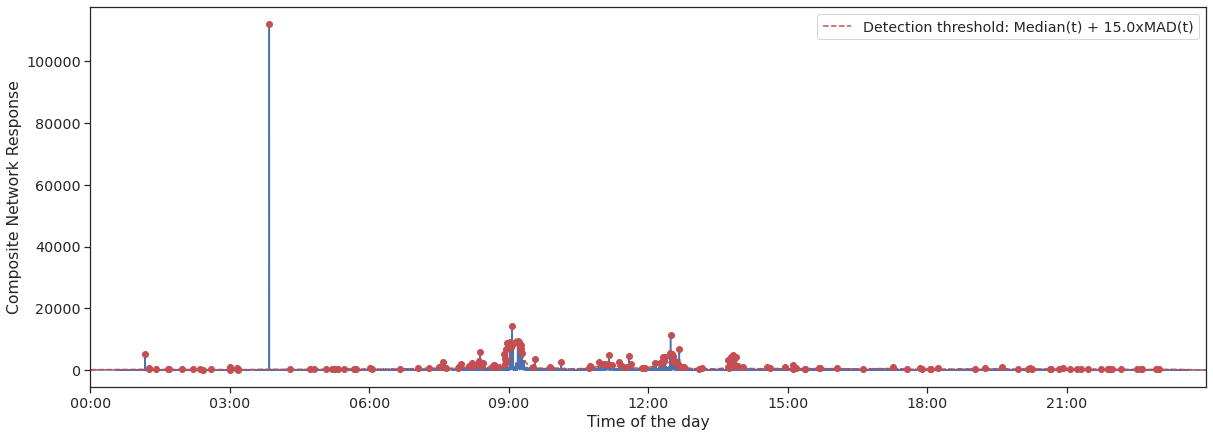

In [13]:
# plot the composite network response
%matplotlib inline
fig = plot_cnr()

In [16]:
def plot_detection(i):
    components = ['N', 'E', 'Z']
    fig = plt.figure(f'detection_{i:d}', figsize=(20, 20))
    grid = fig.add_gridspec(nrows=len(network_metadata)+2, ncols=len(components),
                            hspace=0.35)
    start_times, end_times = [], []
    wav_axes = []
    ax_cnr = fig.add_subplot(grid[:2, :])
    plot_cnr(ax=ax_cnr, det_idx=i)
    ax_cnr.set_ylim(-10., 2.*cnr[peaks[i]])
    beam = 0.
    for s, sta in enumerate(network_metadata['station_code']):
        for c, cp in enumerate(components):
            ax = fig.add_subplot(grid[2+s, c])
            tr = detections[i].select(station=sta, component=cp)[0]
            time = np.arange(
                np.datetime64(tr.stats.starttime), np.datetime64(tr.stats.endtime)+np.timedelta64(int(1000./sr), 'ms'),
                np.timedelta64(int(1000./sr), 'ms'))
            start_times.append(time[0])
            end_times.append(time[-1])
            ax.plot(time, tr.data, color='k')
            ax.axvline(time[0] + np.timedelta64(int(1000.*offset_start[c]), 'ms'), color='C3')
            ax.text(0.05, 0.05, f'{sta}.{cp}', transform=ax.transAxes)
            wav_axes.append(ax)
    for ax in wav_axes:
        ax.set_xlim(min(start_times), max(end_times))
        ax.xaxis.set_major_formatter(
            mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    return fig

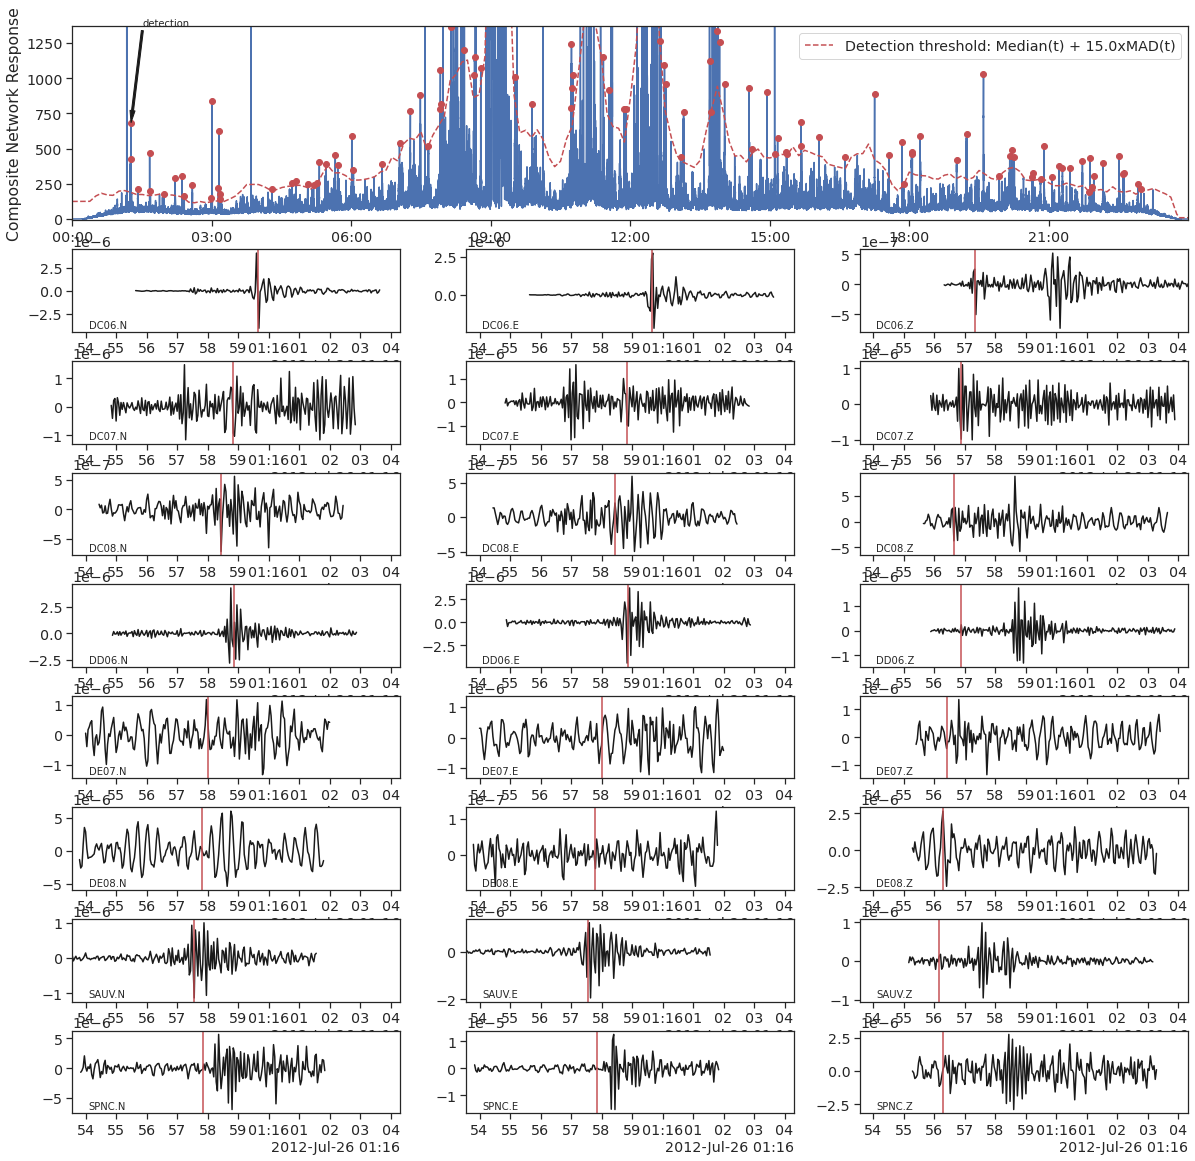

In [17]:
%matplotlib inline
fig = plot_detection(2)

In [ ]:
# for i in range(len(detections)):
#     fig = plot_detection(i)